# OH NO

A virus is coming where 50% of the cryptopunks will have contracted a disease where they get a white spot. The code below generates the disease. Your job is as follows

1. Generate the data as below
2. Train a convolutional neural network to classify punks as diseased or not
   1. Create training and validation sets. Contrast in the sensitivity, specificity and accuracy in both sets.
   2. Visualize some of your algorithm's mistakes (in both directions) and describe what is happening. In other words, consider punks declared very likely to have a cancer that did not and ones that did not have a cancer that it declared very likely that they did. Plot those. Is there a reason why it seems like it's so wrong for these cases?
   3. Create a python function that takes in an np image array just like the cancerpunks one below and gives probabilities that that punk has this disease.

In [1]:

import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

## Open the image
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

n = 10000

finalArray = np.empty((n, 24, 24, 3))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:]


Our doctors have determined this is the region where the lesion occurs.

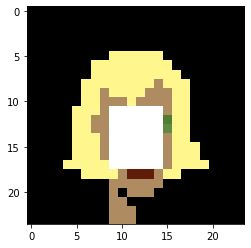

In [2]:

temp  =  finalArray[0,:,:,:].copy()

d2min, d2max = 9,14 
d1min, d1max = 11,17

temp[d1min : (d1max + 1), d2min : (d2max + 1)] = 255

plt.imshow(temp.astype('uint8'))



# Generating Data for Punks having cancer

In [3]:
cancerpunks = finalArray.copy()
label = np.zeros(n)

## Loop over the cryptopunks
for i in range(10000):
  flip = np.random.randint(0, 2)
  if flip is 1:
    label[i] = 1
    d1loc = np.random.randint(d1min, d1max + 1)
    d2loc = np.random.randint(d2min, d2max + 1)
    cancerpunks[i,d1loc,d2loc,:] = 255



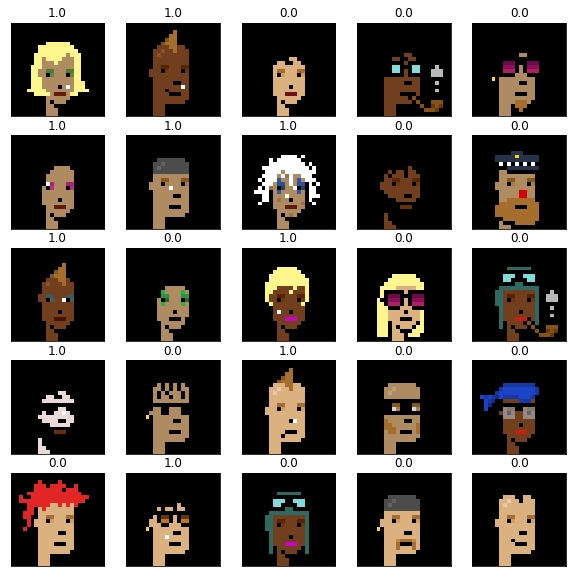

In [4]:
## plot some examples
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cancerpunks[i,:,:,:].astype('uint8'))
  plt.title(label[i])

# Creating Training and Validation Sets

In [5]:
arr=np.empty((2400,2400,3))

for i in range(100):
  for j in range(100):
    a,b =24*i,24* (i+1)
    c,d =24*j,24* (j+1)
    idx=j+i *(100)
    arr[a:b,c:d,:]=cancerpunks[idx,:,:,:]

final = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    final[idx,0,:,:] = arr[a:b,c:d,0]
    final[idx,1,:,:] = arr[a:b,c:d,1]
    final[idx,2,:,:] = arr[a:b,c:d,2]

n = final.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = final[ sample, :, :, :] / 255
x_test =  final[~sample, :, :, :] / 255
print([x_train.shape, x_test.shape])

y_train = label[sample]
y_test =  label[~sample]

## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

[(7478, 3, 24, 24), (2522, 3, 24, 24)]


# Creating Neural Network

In [6]:
import torch 
torch.manual_seed(10)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

trainDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        ## This has to be changed because the size
        ## of our inputs is different than the CFAR
        ## example. There's is 32x32 and ours is 24x24
        ## Also, I changed the rest of the network architecture
        ## here
        ## Finally, we only have one output.
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()

In [8]:
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

In [9]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Running Neural Network for training and testing data sets. 
## Insample: Training
## Outsample: Testing

In [10]:
insample = net(torch.Tensor(x_train)).detach().numpy()
outsample= net(torch.Tensor(x_test)).detach().numpy()


# Specificity and Sensitivity in terms of ROC i.e. False Positive Rate and True Positive Rate

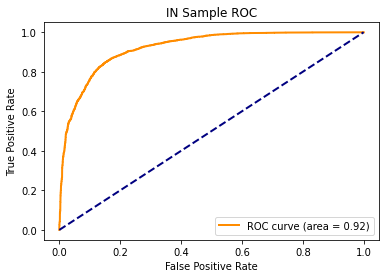

In [19]:
from sklearn.metrics import accuracy_score, roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, insample)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('IN Sample ROC')
plt.legend(loc="lower right")
plt.show()

dist=np.sqrt(((fpr-0)**2)+((tpr-1)**2))
j=np.argmin(dist)
in_sample_t=thresholds[j]

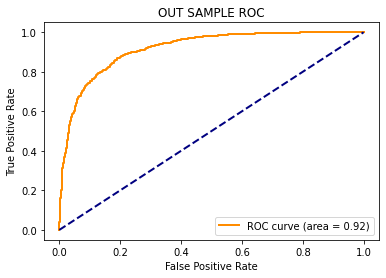

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, outsample )
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OUT SAMPLE ROC')
plt.legend(loc="lower right")
plt.show()

dist=np.sqrt(((fpr-0)**2)+((tpr-1)**2))
j=np.argmin(dist)
out_sample_t=thresholds[j]

# We find the accuarcy at the Operating Point for both situations. The operating point is the point where there is maximum sensitivity and specificity. Point on the ROC Curve closest to the coordinate (0,1).  

In [34]:
in_y_label=np.zeros(len(insample))
out_y_label= np.zeros(len(outsample))

in_l=len(insample)
out_l=len(outsample)
for i in range(in_l):
  if insample[i]>in_sample_t:
    in_y_label[i]=1

for j in range(out_l):
  if outsample[j]>in_sample_t:
    out_y_label[j]=1

in_acc=np.mean(in_y_label==y_train)
out_acc=np.mean(out_y_label==y_test)

print('Insample Accuracy is ',in_acc)
print('Outsample Accuracy is',out_acc)

Insample Accuracy is  0.500024534837717
Outsample Accuracy is 0.4981058045268253


In [12]:
x_train_new=cancerpunks[sample,:,:,:]
x_test_new=cancerpunks[~sample,:,:,:]

First 25 In Sample Errors


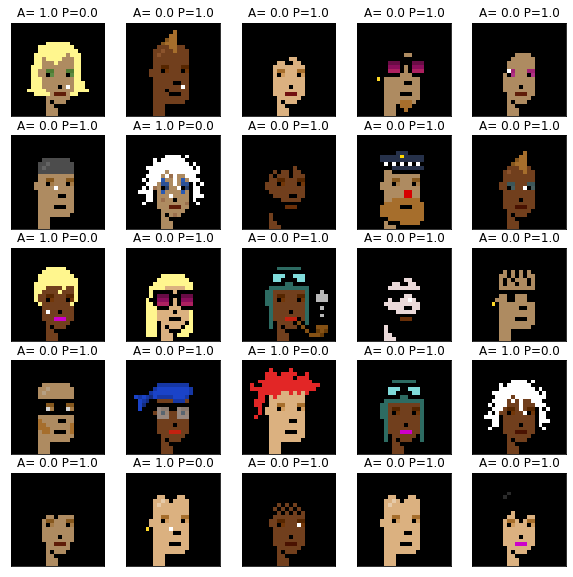

In [13]:
print('First 25 In Sample Errors')
j=0;
plt.figure(figsize=(10,10))
for i in range(in_l):
  if(in_y_label[i]!=y_train[i]):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_new[j,:,:,:].astype('uint8'))
    plt.title('A= {0} P={1}'.format(y_train[i][0],in_y_label[i]))
    j=j+1
    if(j==25):
      break

First 25 Out Sample Errors


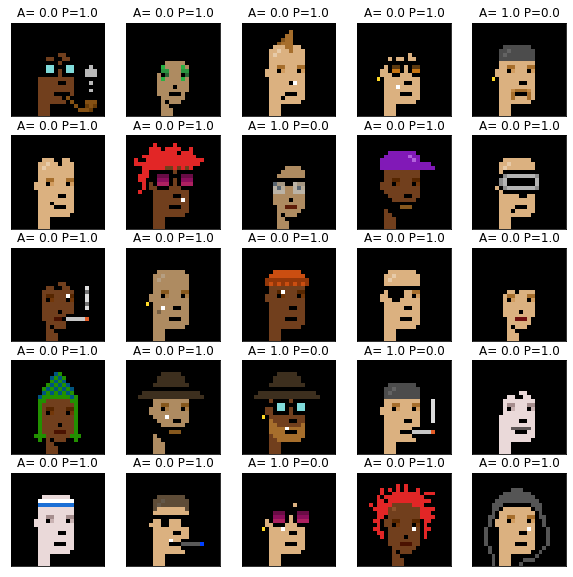

In [14]:
print('First 25 Out Sample Errors')
j=0;
plt.figure(figsize=(10,10))
for i in range(in_l):
  if(out_y_label[i]!=y_test[i]):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_new[j,:,:,:].astype('uint8'))
    plt.title('A= {0} P={1}'.format(y_test[i][0],out_y_label[i]))
    j=j+1
    if(j==25):
      break

# Function

In [15]:
def give_prob(inpt):
  arr=np.empty((2400,2400,3))
  for i in range(100):
    for j in range(100):
      a,b =24*i,24* (i+1)
      c,d =24*j,24* (j+1)
      idx=j+i *(100)
      arr[a:b,c:d,:]=inpt[idx,:,:,:]
      
  final = np.empty((10000, 3, 24, 24))
  for i in range(100):
    for j in range(100):
      a, b = 24 * i, 24 * (i + 1)  
      c, d = 24 * j, 24 * (j + 1) 
      idx = j + i * (100)
      final[idx,0,:,:] = arr[a:b,c:d,0]
      final[idx,1,:,:] = arr[a:b,c:d,1]
      final[idx,2,:,:] = arr[a:b,c:d,2]
  final=final[:,:,:,:]/255

  outp=net(torch.Tensor(final)).detach().numpy()
  return outp

In [16]:
yy=give_prob(cancerpunks)